# Project : *A Bayesian reassessment of nearest-neighbour classification*
### Tom Rivero, Sacha Dedeken | M2 Data Science | Bayesian Machine Learning

#### Step 1 : Import packages and dataset

We use [the original KNN from the scikit learn library](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), and data of [the Haberman's Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival) from the UCI Machine Learning Repository. 

As you can see below, the dataset contains the survival of 306 patients (age, year of the operation, number of positive axillary nodes) 5 years after having undergone surgery for breast cancer between 1958 and 1969. So we have $X \in \mathbb{N}^{306\times3}$ and $y \in \{0,1\}^{306}$. The goal is to do binary classification on $y$ based on $X$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("haberman.data", names=["age", "operation_year", "nodes", "survival_status"])
df["survival_status"] -= 1
df
"""df_ripley_tr = pd.read_fwf('synth.tr')
df_ripley_te = pd.read_fwf('synth.te')
df_ripley_tr.plot.scatter(x="xs", y="ys", c="yc", colormap='viridis');"""

'df_ripley_tr = pd.read_fwf(\'synth.tr\')\ndf_ripley_te = pd.read_fwf(\'synth.te\')\ndf_ripley_tr.plot.scatter(x="xs", y="ys", c="yc", colormap=\'viridis\');'

In [3]:
df.describe()

,age,operation_year,nodes,survival_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,0.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,0.000000
25%,44.000000,60.000000,0.000000,0.000000
50%,52.000000,63.000000,1.000000,0.000000
75%,60.750000,65.750000,4.000000,1.000000
max,83.000000,69.000000,52.000000,1.000000


We split randomly the dataset into a train and a test set.

In [29]:
X, y = df[df.columns[:-1]].to_numpy(), df[df.columns[-1]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

K = min(np.unique(y_train, return_counts=True)[1]) # =64, maximum K we can pick for knn
print(K)

64


In [ ]:
# ripley dataset

def create_X_y(df_tr, df_te):
    X_tr = df_tr[["xs", "ys"]].to_numpy()
    y_tr = df_tr["yc"].to_numpy()
    X_te = df_te[["xs", "ys"]].to_numpy()
    y_te = df_te["yc"].to_numpy()
    return X_tr, y_tr, X_te, y_te

# Warning : X_tr, y_tr, X_te, y_te are then global parameters in the following functions.
X_train, y_train, X_test, y_test = create_X_y(df_ripley_tr, df_ripley_te)
K = min(np.unique(y_train, return_counts=True)[1])
print(K)

125


#### Step 2 : Probabilistic modelling

In [5]:
def all_k_neighbors(K, X, point_to_pred=None):
    """Computes once every k-neighbors of every points for k in {1,K}

    Args:
        K (int): maximum number of neighbors
        X (2D-array): trainset
        point_to_pred (1D-array): point from test set that one wants to predict, default to None

    Returns:
        3D-list : each index i of the list contains the 2D-array containing the i-neighbors_graph

    """
    if point_to_pred is not None:
        X = np.append(X, np.array([point_to_pred]), axis=0) #append point to pred to X in order to later be able to compute its symetric potts

    M = [None] #set first raw to none since it correspond to k=0
    for n in range(1,K+1):
        graph_n = kneighbors_graph(X, n)
        M.append(graph_n.toarray())
    return M


def symetric_potts(i, y_i, y, Mk):
    """Computes symetric potts as described in equation (4)

    Args:
        i (int): index of point we want to compute the symetric potts
        y_i (int): class of point i
        y (1D-array): array of labels of training points
        Mk (2D-array):  a kneighbors_graph

    Returns:
        int: symetric potts
    """
    #left part : number of neighbors of point i having label y_i
    neighbors_index = np.nonzero(Mk[i])[0]
    sp1 = np.sum(y[neighbors_index] == y_i)

    #right part : number of points that have point i in their k-neighbourhood
    neighbors_index = np.nonzero(Mk[:, i])[0] #get column instead of row
    sp2 =  np.sum(y[neighbors_index] == y_i)

    return sp1 + sp2

#### Step 3 : Pseudo-likelihood approximation

In [6]:
def log_pseudo_likelihood_approx(y, beta, k, Mk):
    """"Computes the log of f_hat from formula (8) on page 12

    Args:
        y (1D-array) : array of labels of training
        beta (float) : beta parameter in the formula
        k (int) : k parameter in the formula
        Mk (2D-array) : a kneighbor_graph

    Returns:
        float : log of f_hat from formula (8) on page 12
    """
    nb_points = len(y)
    num, den0, den1 = np.zeros(nb_points), np.zeros(nb_points), np.zeros(nb_points)

    for i in range(nb_points):
        sp0 = symetric_potts(i, 0, y_train, Mk)
        sp1 = symetric_potts(i, 1, y_train, Mk)
        
        num[i] = sp0 if y[i]==0 else sp1
        den0[i] = sp0
        den1 = sp1

    num = np.exp((beta/k)*num)
    den = np.exp((beta/k)*den0) + np.exp((beta/k)*den1)   

    num = np.sum(np.log((num)))
    den = np.sum(np.log((den)))
    return num - den

def log_prob_posterior(y, beta, k, theta, M):
    """"

    Args:
        y (1D-array) : array of labels of training
        beta (float) : beta parameter in the formula
        k (int) : k parameter in the formula
        M (3D-array) : the kneighbor_graph matrices

    Returns:
        float : 
    """
    f = log_pseudo_likelihood_approx(y, beta, k, M[k])
    # change of variable of theta to beta
    exp = theta - 2 * np.log(1 + np.exp(theta)) #??????????????

    return f + exp

In [7]:
# Metropolis Hasting
def Q_r(k, r):
  """A uniform distribution on the 2r neighbours of k"""
  neighbours = range(max(1,k-r), min(K,k+r+1))
  return 1 / len(neighbours)

def acceptance_probability(y, beta, k, new_k, theta, r, M, log_posterior, new_log_posterior):
    
  Q = Q_r(k, r) / Q_r(new_k, r)
  r = np.exp( new_log_posterior - log_posterior ) #ratio of (non-log) posteriors

  rho = min(r / Q, 1)

  return rho

In [8]:
def metropolis_hasting(r, tau2, beta_max, K, y, X, steps, burn_in_stage):

    samples = np.zeros((steps-burn_in_stage,2))

    # Initialisation of M and parameters 
    M = all_k_neighbors(K, X)
    k = int(K/2)
    theta = 0
    beta = beta_max * np.exp(theta)/(np.exp(theta)+1)
    log_posterior = log_prob_posterior(y, beta, k, theta, M)

    for i in tqdm(range(steps)):
        #update parameters
        new_k = np.random.choice(range(max(1,k-r), min(K+1, k+r+1))) #draw new k uniformly on the 2r neighbours of old_k
        new_theta = np.random.normal(theta, tau2) #Draw new theta from a normal distribution N(old_theta, tau^2)
        new_beta = beta_max * np.exp(theta)/(np.exp(theta)+1) #logistic reparameterisation of beta (bottom of page 11 in the paper)

        # acceptance probability
        new_log_posterior = log_prob_posterior(y, beta, new_k, theta, M)
        rho = acceptance_probability(y, new_beta, k, new_k, new_theta, r, M, log_posterior, new_log_posterior)
        
        u = np.random.rand()

        if rho > u : #accept the update
            k, theta, beta = new_k, new_theta, new_beta
            log_posterior = new_log_posterior
            
        if i >= burn_in_stage: #store evolution of variables
            samples[i-burn_in_stage-1] = [k, beta]
        

    return samples

In [19]:
def plots(samples, t):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(samples)), samples)
    plt.title(t)
    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=K)
    plt.show()

In [30]:
samples = metropolis_hasting(r=3, tau2=0.05, beta_max=4, K=K,
            y=y_train, X=X_train,
            steps=50000, burn_in_stage=40000)

  1%|          | 453/50000 [00:13<19:24, 42.55it/s]

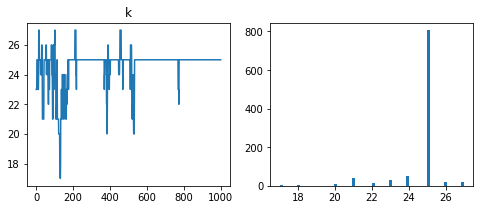

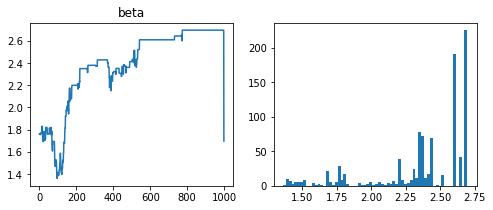

In [31]:
samples_k = samples[:,0]
samples_beta = samples[:,1]
plots(samples_k, 'k')
plots(samples_beta, 'beta')

In [32]:
def predict_probas(samples, X_test):

    y_hat = np.zeros((len(X_test), 2))
    for j in tqdm(range(len(X_test))):
        M_pred = all_k_neighbors(K, X_train, X_test[j]) #computes neighbors of point j and point that have point j in their neighborhood 
        probas = np.zeros((len(samples), 2))
        preds = np.zeros(len(samples))
        for i, s in enumerate(samples):
            k, beta = s
            p0 = np.exp((beta/k)*symetric_potts(-1, 0, y_train, M_pred[int(k)])) #proba of point j to have label 0
            p1 = np.exp((beta/k)*symetric_potts(-1, 1, y_train, M_pred[int(k)])) #proba of point j to have label 1
            p = np.array([p0, p1])
            probas[i] = p / np.sum(p) #normalize to have proper probabilities

        y_hat[j] = np.mean(probas, axis=0) #final estimated probabilities for point j 

    return y_hat

In [33]:
y_hat = predict_probas(samples, X_test)

100%|██████████| 62/62 [00:25<00:00,  2.40it/s]


In [37]:
#print(y_hat)
#print(y_test)
#print(np.argmax(y_hat, axis=1))
print(1-(np.sum(np.abs(np.argmax(y_hat, axis=1) - y_test)))/ len(y_test))

0.7258064516129032


# --------------------------

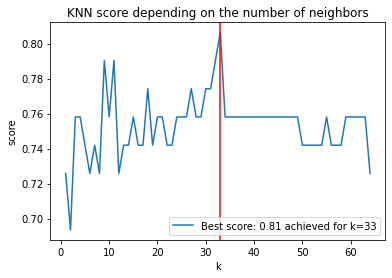

In [35]:
K_list = range(1, K+1)
scores = []
for n in K_list:
    my_KNN = KNeighborsClassifier(n_neighbors=n)
    my_KNN.fit(X_train, y_train)
    scores.append(my_KNN.score(X_test, y_test))
    
best_score = max(scores)
best_k = np.argmax(scores)+1

plt.plot(K_list, scores, label="Best score: "+str(np.round(best_score,2))+" achieved for k="+str(best_k))
plt.axvline(best_k, c="r")
plt.title("KNN score depending on the number of neighbors")
plt.xlabel("k")
plt.ylabel("score")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3b829252-08cb-4f6e-a65c-5242d23c5d16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>